In [1]:
import matplotlib.pyplot as plt
from einops import rearrange

import torch
import torch.nn.functional as F


from monai.transforms import ScaleIntensity
from monai.config import print_config

from scripts.train import LitUnet
from scripts.data import CentreDataModule
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning import seed_everything

%load_ext autoreload
%autoreload 2

from scripts.utils import *

#print_config()
from itertools import islice


def display_subplot(data, title, ax, cmap="gray"):
    ax.imshow(data, cmap=cmap)
    ax.set_title(title)
    ax.axis('off')

def predict_and_display_examples(model, batch_index, loader, centre):
    seed_everything(42, workers=True)

    it = iter(loader)
    batch = next(islice(it, batch_index-1,batch_index))
    x, y = batch
    n = len(x)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    x = x.to(device)

    with torch.no_grad():
        model.eval()
        pred = model(x)
    prob = F.softmax(pred, dim=1)
    y_pred = torch.argmax(prob, dim=1).cpu()

    fig, axes = plt.subplots(3, 1, figsize=(n, 5))
    fig.suptitle(f"Image Predictions and Ground Truth for center {centre}", fontsize=16)
    
    display_subplot(rearrange(x.cpu()[:n+1], "b c h w -> h (b w) c"), "Images", axes[0])
    display_subplot(rearrange(y_pred[:n+1], "b h w -> h (b w)"), "Predictions", axes[1], cmap="viridis")
    display_subplot(rearrange(y[:n+1], "b h w -> h (b w)"), "Ground Truth", axes[2], cmap="viridis")

    plt.tight_layout()
    plt.show()

/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed_everything(42, workers=True)

model = LitUnet(lr=1e-3)

Global seed set to 42


In [3]:
transform =  ScaleIntensity(minv=0.0, maxv=1.0, channel_wise=True)
dm = CentreDataModule("A", train_centre=6, split_ratio=0.7, load_transform=transform, batch_size=8)
# Training and Validation
trainer = pl.Trainer(max_epochs=50, 
                     deterministic=True, 
                     logger=True,
                     log_every_n_steps=1, 
                     enable_model_summary=False,
                     callbacks=[EarlyStopping('val_loss', patience=2)], 
                     fast_dev_run=False)
trainer.fit(model, datamodule=dm)
trainer.save_checkpoint("checkpoints/benchmark_deterministic.ckpt")

/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/lightning_fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-pac ...
  rank_zero_warn(


total number of samples: 95, train samples: 66, Validation: 29


Loading Images/Labels:: 100%|██████████| 29/29 [00:00<00:00, 80.62File/s]
/home/ids/mahdi-22/M-M/.venv/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory /home/ids/mahdi-22/M-M/lightning_logs/version_39210/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 10: 100%|██████████| 195/195 [00:06<00:00, 29.90it/s, v_num=39210, val_loss=0.0591, train_loss=0.0395]


Global seed set to 42


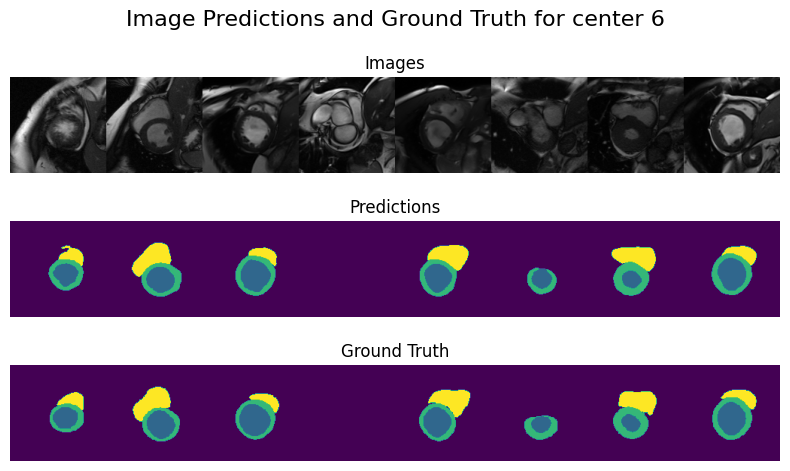

Global seed set to 42


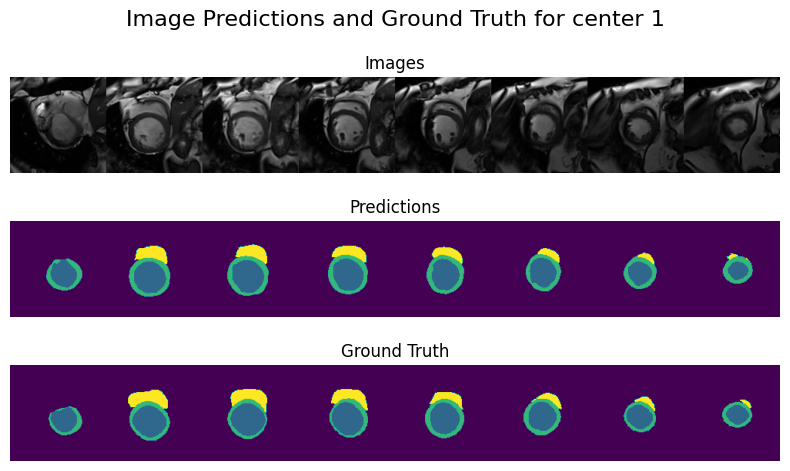

In [4]:
model = LitUnet.load_from_checkpoint("checkpoints/benchmark_deterministic.ckpt")
batch_index = 3
transform =  ScaleIntensity(minv=0.0, maxv=1.0, channel_wise=True)

train_dataloader = dm.train_dataloader()
predict_and_display_examples(model, batch_index, train_dataloader, 6)

val_dataloader = dm.val_dataloader()
predict_and_display_examples(model, batch_index, val_dataloader, 1)

In [42]:
trainer.test(ckpt_path="best", datamodule=dm)

Loading Images/Labels:: 100%|██████████| 66/66 [00:00<00:00, 75.68File/s]
Restoring states from the checkpoint path at /home/ids/mahdi-22/M-M/lightning_logs/version_39210/checkpoints/epoch=10-step=2145-v7.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at /home/ids/mahdi-22/M-M/lightning_logs/version_39210/checkpoints/epoch=10-step=2145-v7.ckpt


Testing: 1it [00:32, 32.10s/it]
Testing DataLoader 5: 100%|██████████| 66/66 [00:21<00:00,  3.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.05907154347426737    │    0.07059815582702761    │    0.05236804174457443    │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 3        ┃       DataLoader 4        ┃       DataLoader 5        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.06769312220450134    │    0.09842617480538117    │    0.03938731258060311    │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'test_loss/dataloader_idx_0': 0.05907154347426737},
 {'test_loss/dataloader_idx_1': 0.07059815582702761},
 {'test_loss/dataloader_idx_2': 0.05236804174457443},
 {'test_loss/dataloader_idx_3': 0.06769312220450134},
 {'test_loss/dataloader_idx_4': 0.09842617480538117},
 {'test_loss/dataloader_idx_5': 0.03938731258060311}]

In [8]:
test_loader = dm.test_dataloader()[0]

Global seed set to 42


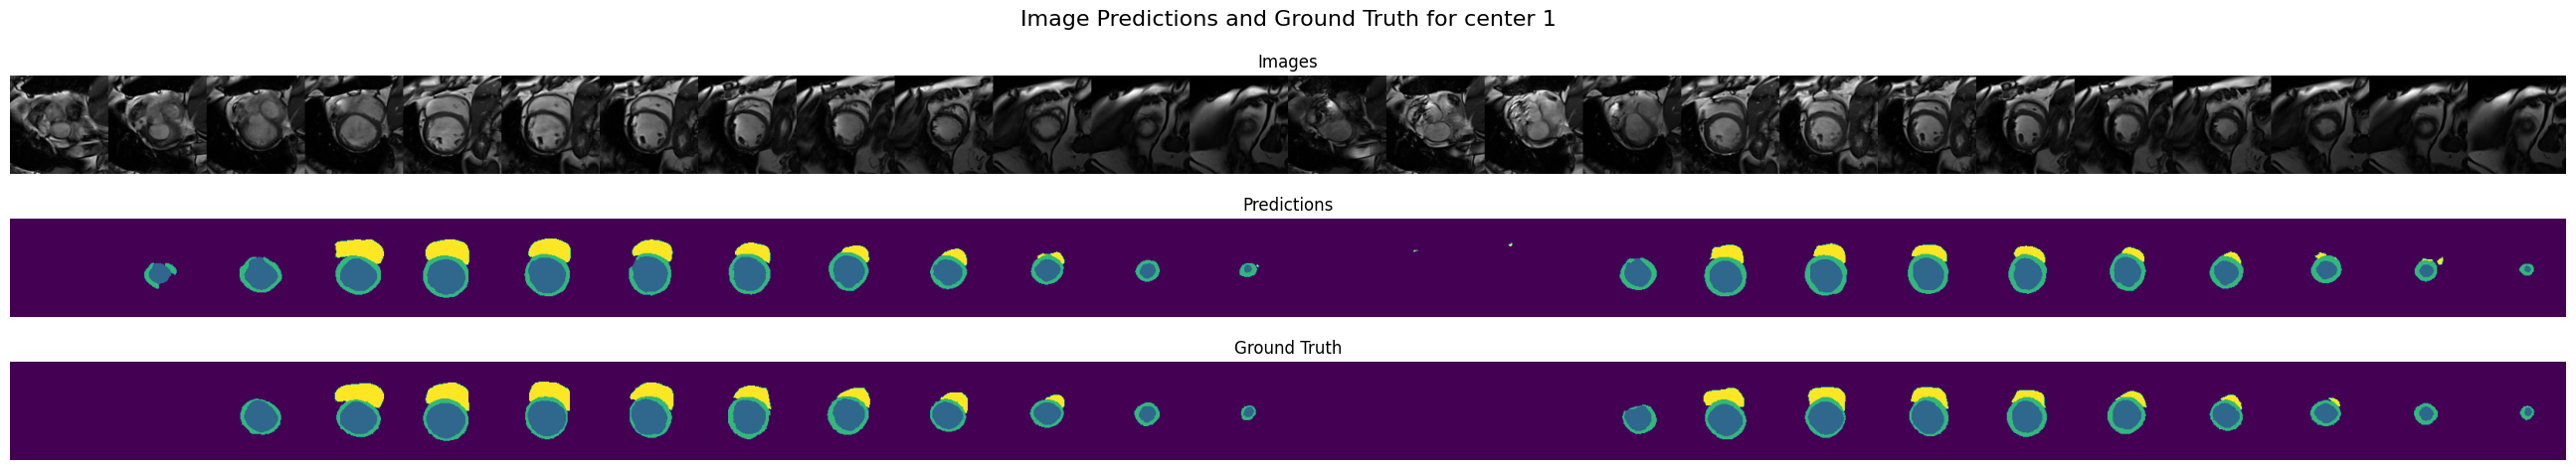

In [10]:
predict_and_display_examples(model, 1, test_loader, 1)